# Fair K-center: Bias measuring and mitigation in clustering tasks

The bias problem can appear in models when the predictions systematically deviate from the true values for certain subgroups in the dataset. This phenomenon can occur due to various reasons such as unbalanced groups in the training data, feature selection, or model specification. Because of this, the bias problem can appear in different tasks, being "clustering task" one of them. 

There are various techniques to measure bias in clustering tasks. One common approach is to use fairness metrics such as Fair K-Center Clustering, Fair K-Median Clustering, Fairlet Clustering, Variational Fair Clustering etc.

Once bias is detected, we can employ different techniques to mitigate it. These methods can be grouped into three categories: Pre-processing, in-processing and post-processing methods. Pre-processing techniques are used to adjust the training data to remove bias, while in-processing methods are applied to build robust models against bias. Finally, post-processing techniques are used to adjust the model's predictions to remove bias.

Through this tutorial, we pretend to present you tools which can be easily applied to measure and mitigate the presence of bias in clustering models.

We will follow the traditional outline for this tutorial:

1. Data tasks
    
    1.1 Imports

    1.2 Data exploration
    
    1.3 Dataset preprocessing
2. Train Baseline
3. Train Model with Mitigator
4. Using Pipeline
5. Summary

## 1. Data Tasks

The dataset that we will use is the "Heart Failure Clinical Records" dataset which is a publicly available dataset that contains the medical records of 299 patients who had heart failure, collected during their follow-up period, where each patient profile has 13 clinical features. The objective is to predict if the patient deceased during the follow-up period.

Source: [UCI ML repository](https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records)

### 1.1 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../../../../')

### 1.2 Data Exploration

In [2]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


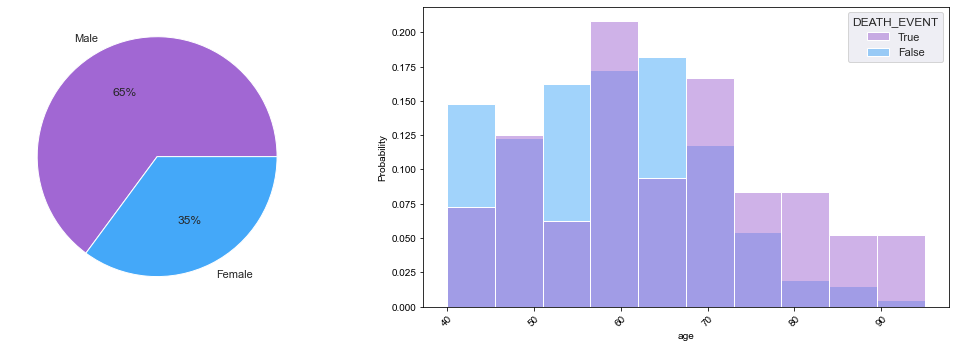

In [3]:
from holisticai.bias.plots import group_pie_plot, histogram_plot

fig, axes = plt.subplots(nrows = 1, ncols =2, figsize=(15,5))
group_pie_plot(df['sex'].replace({1:'Male', 0:'Female'}), ax = axes[0])
histogram_plot(df['age'], df['DEATH_EVENT'].replace({1:'True', 0:'False'}), ax = axes[1])
plt.tight_layout()

In [4]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

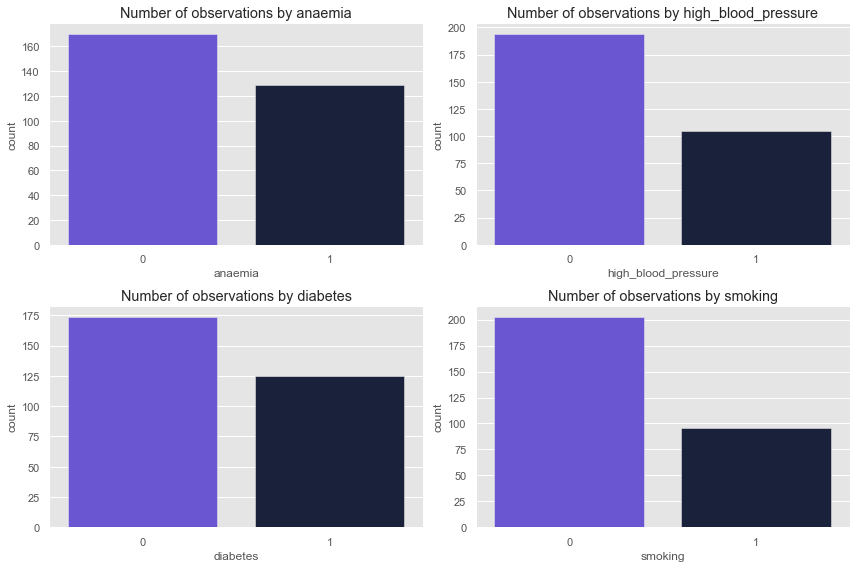

In [5]:
colors = ["#5b42e4", "#141e41"]
plt.style.use('ggplot')
haiPallete = sns.set_palette(sns.color_palette(colors))

fig, axes = plt.subplots(ncols=2, nrows= 2, figsize=(12,8))
cols = ['anaemia', 'high_blood_pressure','diabetes','smoking']
for i, ax in zip(cols, axes.flat):
    sns.countplot(x=i, data=df, ax = ax, palette=haiPallete).set_title(f'Number of observations by {i}')
    plt.tight_layout()

### 1.3 Pre-processing

In [6]:
from sklearn.model_selection import train_test_split

# Dataframe
protected_variables = ["sex", "age"]
output_variable = ["DEATH_EVENT"]

# Simple preprocessing
y = df[output_variable]
X = df.drop(protected_variables + output_variable, axis=1)

group_a = df['sex'] == 0
group_b = df['sex'] == 1

X_train,X_test,y_train,y_test, group_a_tr, group_a_ts, group_b_tr, group_b_ts = \
    train_test_split(X, y, group_a, group_b, test_size=0.2, random_state=42)
train_data = X_train, y_train, group_a_tr, group_b_tr
test_data  = X_test, y_test, group_a_ts, group_b_ts

## 2. Train Baseline

In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

ks = range(1, 8)
inertias = []
X_train, _, group_a, group_b = train_data

scaler = StandardScaler()
X_t = scaler.fit_transform(X_train)

for k in ks:
    # create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k)

    # fit model to samples
    model.fit(X_t)

    # append the inertia to the list of inertias
    inertias.append(model.inertia_)

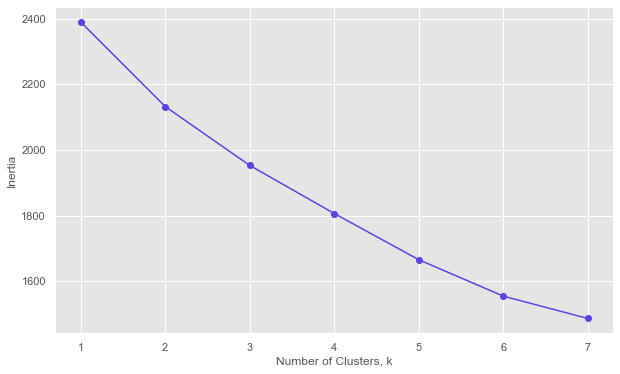

In [8]:
# Plot ks vs inertias
plt.figure(figsize=(10,6))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

In [9]:
from holisticai.bias.metrics import clustering_bias_metrics

# we choose to use 3 clusters
model = KMeans(n_clusters = 3, random_state=42)
model.fit(X_t)

# predict
y_pred = model.predict(X_t)

centroids = model.cluster_centers_

df_baseline = clustering_bias_metrics(group_a, group_b, y_pred, data = X_t, centroids = centroids, metric_type = 'equal_outcome')
df_baseline

,Value,Reference
Metric,,
Cluster Balance,0.112471,1
Minimum Cluster Ratio,0.041667,1
Cluster Distribution Total Variation,0.432238,0
Cluster Distribution KL Div,0.482422,0
Social Fairness Ratio,1.035361,1
Silhouette Difference,0.006640,0


1. **Cluster Balance:** Given a clustering and protected attribute. The cluster balance is the minimum over all groups and clusters of the ratio of the representation of members of that group in that cluster to the representation overall. A value of 1 is desired. That is when all clusters have the exact same representation as the data. Lower values imply the existence of clusters where either group_a or group_b is underrepresented.

2. **Minimum Cluster Ratio:** Given a clustering and protected attributes. The min cluster ratio is the minimum over all clusters of the ratio of number of group_a members to the number of group_b members. A value of 1 is desired. That is when all clusters are perfectly balanced. Low values imply the existence of clusters where group_a has fewer members than group_b.

3. **Cluster Distribution Total Variation:** This function computes the distribution of group_a and group_b across clusters. It then outputs the total variation distance between these distributions. A value of 0 is desired. That indicates that both groups are distributed similarly amongst the clusters. The metric ranges between 0 and 1, with higher values indicating the groups are distributed in very different ways.

4. **Cluster Distribution KL Div:** This function computes the distribution of group_a and group_b membership across the clusters. It then returns the KL distance from the distribution of group_a to the distribution of group_b. A value of 0 is desired. That indicates that both groups are distributed similarly amongst the clusters. Higher values indicate the distributions of both groups amongst the clusters differ more.

5. **Social Fairness Ratio:** Given a centroid based clustering, this function compute the average distance to the nearest centroid for both groups. The metric is the ratio of the resulting distance for group_a to group_b. A value of 1 is desired. Lower values indicate the group_a is on average closer to the respective centroids. Higher values indicate that group_a is on average further from the respective centroids.

6. **Silhouette Difference:** We compute the difference of the mean silhouette score for both groups. The silhouette difference ranges from -1 to 1, with lower values indicating bias towards group_a and larger values indicating bias against group_b.


## 3. Train Model with Mitigator

### In-processing: Fair K-median Clustering 

The **Fair K-median Clustering** inprocessing bias mitigation is an approximation algorithms for group representative k-median clustering. The algorithm reduces the max group cost function.

#### Traditional Implementation

In [10]:
from holisticai.bias.mitigation import FairKmedianClustering

# set inprocessing model
inprocessing_model = FairKmedianClustering(n_clusters=2, strategy='GA')

# fit inprocessing model
inprocessing_model.fit(X_t, group_a= group_a, group_b = group_b)

# predict
y_pred = inprocessing_model.labels_

# set up data arrays
centroids = inprocessing_model.cluster_centers_

df_fair_kmedian = clustering_bias_metrics(group_a, group_b, y_pred, data = X_t, centroids = centroids, metric_type = 'equal_outcome')
df_fair_kmedian

Cost: 6.4311:   0%|          | 0/1000 [00:05<?, ?it/s]


,Value,Reference
Metric,,
Cluster Balance,0.880654,1
Minimum Cluster Ratio,0.467391,1
Cluster Distribution Total Variation,0.091520,0
Cluster Distribution KL Div,0.017092,0
Social Fairness Ratio,0.986925,1
Silhouette Difference,0.002576,0


Below we tested different number of clusters to observe the behavior of metrics. Podemos observar que 

Cost: 4.5609:   0%|          | 0/1000 [00:22<?, ?it/s]


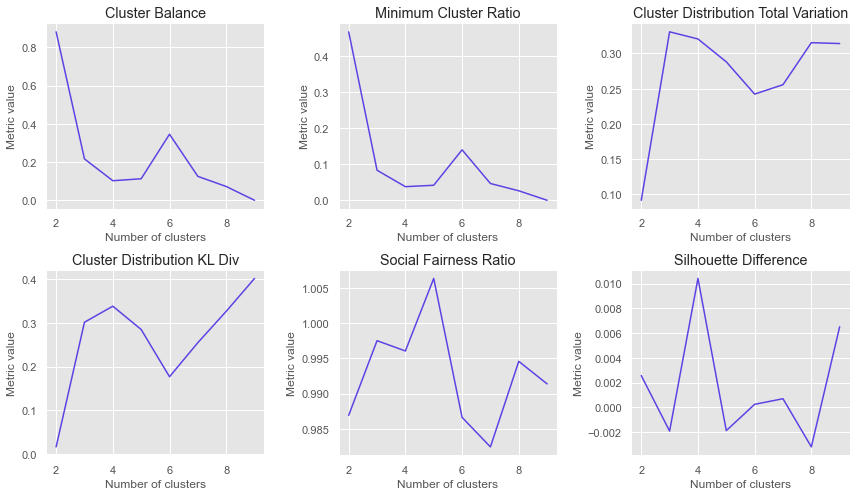

In [11]:
metric_names = ['Cluster Balance', 'Minimum Cluster Ratio', 'Cluster Distribution Total Variation', 'Cluster Distribution KL Div', 'Social Fairness Ratio', 'Silhouette Difference']

metric_values = []
for j in range(2, 10):
    # set inprocessing model
    inprocessing_model_range = FairKmedianClustering(n_clusters=j, strategy='GA')

    # fit inprocessing model
    inprocessing_model_range.fit(X_t, group_a= group_a, group_b = group_b)

    # predict
    y_pred_range = inprocessing_model_range.labels_

    # set up data arrays
    centroids_range = inprocessing_model_range.cluster_centers_

    df_fair_kcenter_range = clustering_bias_metrics(group_a, group_b, y_pred_range, data = X_t, centroids = centroids_range,  metric_type = 'equal_outcome')
    metric_values.append(df_fair_kcenter_range['Value'].T)

df_metrics = pd.DataFrame(np.array(metric_values).flatten().reshape(-1,6), columns=metric_names)

fig, axs = plt.subplots(2, 3, figsize=(12, 7))
for i, metric in enumerate(metric_names):
    row = i // 3
    col = i % 3
    axs[row, col].plot(range(2, 10), df_metrics[metric], '-')
    axs[row, col].set_xlabel('Number of clusters')
    axs[row, col].set_ylabel('Metric value')
    axs[row, col].set_title(metric)

plt.tight_layout()
plt.show()

## 4. Using Pipeline

Now that we could see how this method is implemented traditionally, let's try implementing it by using the Scikit-learn Pipeline! Notice that we shouldn't have variations in the metrics for the previous implementation.

In [12]:
from holisticai.pipeline import Pipeline

inprocessing_model = FairKmedianClustering(n_clusters=2, strategy='GA')

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('bm_inprocessing', inprocessing_model)])

# select data
X, _, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a, 
    "bm__group_b": group_b
}

pipeline.fit(X, **fit_params)
y_pred = pipeline['bm_inprocessing'].labels_ 

# set up data arrays
centroids = pipeline['bm_inprocessing'].cluster_centers_
X_t = pipeline['scaler'].transform(X)

df_fair_kmedian_w_p = clustering_bias_metrics(group_a, group_b, y_pred, data = X_t, centroids = centroids, metric_type = 'equal_outcome')
df_fair_kmedian_w_p

Cost: 6.4311:   0%|          | 0/1000 [00:08<?, ?it/s]


,Value,Reference
Metric,,
Cluster Balance,0.880654,1
Minimum Cluster Ratio,0.467391,1
Cluster Distribution Total Variation,0.091520,0
Cluster Distribution KL Div,0.017092,0
Social Fairness Ratio,0.986925,1
Silhouette Difference,0.002576,0


Below we tested different number of clusters to observe the behavior of metrics.

Cost: 4.5883:   0%|          | 0/1000 [00:07<?, ?it/s]


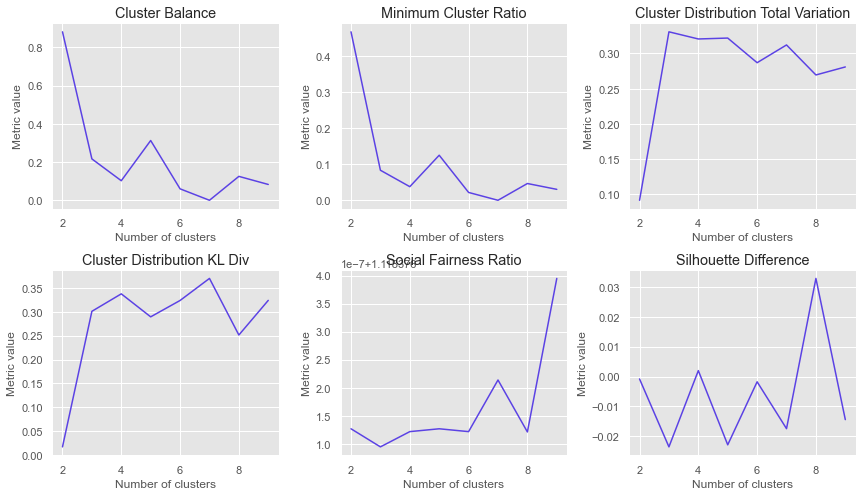

In [13]:
metric_names = ['Cluster Balance', 'Minimum Cluster Ratio', 'Cluster Distribution Total Variation', 'Cluster Distribution KL Div', 'Social Fairness Ratio', 'Silhouette Difference']
num_metrics = len(metric_names)


metric_values = []
for j in range(2, 10):
    inprocessing_model = FairKmedianClustering(n_clusters=j, strategy='GA')

    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('bm_inprocessing', inprocessing_model)])

    # select data
    X, _, group_a, group_b = train_data
    fit_params = {
        "bm__group_a": group_a, 
        "bm__group_b": group_b
    }

    pipeline.fit(X, **fit_params)

    # predict
    y_pred = pipeline['bm_inprocessing'].labels_

    # set up data arrays
    centroids = pipeline['bm_inprocessing'].cluster_centers_
    X_t = pipeline['scaler'].transform(X)
    
    df_fair_kcenter_range = clustering_bias_metrics(group_a, group_b, y_pred, data = X, centroids = centroids, metric_type = 'equal_outcome')
    metric_values.append(df_fair_kcenter_range['Value'].T)

df_metrics = pd.DataFrame(np.array(metric_values).flatten().reshape(-1,6), columns=metric_names)

fig, axs = plt.subplots(2, 3, figsize=(12, 7))
for i, metric in enumerate(metric_names):
    row = i // 3
    col = i % 3
    axs[row, col].plot(range(2, 10), df_metrics[metric], '-')
    axs[row, col].set_xlabel('Number of clusters')
    axs[row, col].set_ylabel('Metric value')
    axs[row, col].set_title(metric)

plt.tight_layout()
plt.show()

## 5. Summary

#### Compare Results

In [14]:
result = pd.concat([df_baseline, df_fair_kmedian, df_fair_kmedian_w_p], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Mitigator without pipeline',"Mitigator with pipeline", 'Reference']
result

,Baseline,Mitigator without pipeline,Mitigator with pipeline,Reference
Metric,,,,
Cluster Balance,0.112471,0.880654,0.880654,1
Minimum Cluster Ratio,0.041667,0.467391,0.467391,1
Cluster Distribution Total Variation,0.432238,0.091520,0.091520,0
Cluster Distribution KL Div,0.482422,0.017092,0.017092,0
Social Fairness Ratio,1.035361,0.986925,0.986925,1
Silhouette Difference,0.006640,0.002576,0.002576,0


Through this tutorial we could present to the user how the `holisticai` library can be easily used to measure the bias present in clustering models by the application of the `clustering_bias_metrics` function, which returns the calculated values for different metrics and their references respectively. 

In addition, we shown how to mitigate the bias by applying some methods, for this opportunity we applied the **Fair-Kmedian-Clustering** to train a fairness model, 